<a href="https://colab.research.google.com/github/kk715/869_course/blob/main/Jane_Street_RMF_with_Tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

jane_street_real_time_market_data_forecasting_path = kagglehub.competition_download('jane-street-real-time-market-data-forecasting')
lonnieqin_jane_street_rmf_keras_model_path = kagglehub.dataset_download('lonnieqin/jane-street-rmf-keras-model')

print('Data source import complete.')


# Jane Street Real-Time Market Data Forecasting with Tensorflow

## Overview
This notebook is designed for a real-time market data forecasting task using TensorFlow. The primary goal is to predict a target variable (responder_6) based on 79 features. This notebook provides a comprehensive workflow for real-time market data forecasting using TensorFlow. It includes data loading, model training, validation, and a submission pipeline for inference. The model is a simple feedforward neural network, and the notebook uses custom metrics and callbacks to enhance training and evaluation.

## Key Components
1. **Configuration**: A configuration class CFG is defined to control whether the model is in training mode or not.

2. **Load traning and validation data**

    **Feature Columns**: The notebook defines 79 feature columns named feature_00 to feature_78.

    **Target Column**: The target column is named responder_6.

    **Training Data**: The training data is loaded from multiple Parquet files partitioned by partition_id. The data is concatenated into X_train (features) and y_train (target).

    **Validation Data**: Similar to training data, validation data is loaded from Parquet files and concatenated into X_val and y_val.


3. **Generators**: Two generator functions (train_generator and validation_generator) are created to yield batches of data for training and validation.
4. **TensorFlow Dataset**
: TensorFlow datasets (train_ds and valid_ds) are created from these generators.
Modeling

5. **Custom Metric**: A custom R² metric (R2Metric) is defined to evaluate the model's performance.

6. **Model Architecture**: A simple feedforward neural network is defined with three hidden layers and a final output layer. The model is compiled with Mean Squared Error (MSE) loss and the custom R² metric.

7. **Training**: The model is trained with callbacks for checkpointing, early stopping, and terminating on NaN loss.


8. **Predict Function**: A predict function is defined to make predictions on test data. The function handles null values, makes predictions using the trained model, and formats the output as required.
9. **Inference Server**: The notebook sets up an inference server using the JSInferenceServer class, which handles the prediction requests.
Execution

The notebook checks if it is running in a competition rerun environment and either serves the inference server or runs a local gateway for testing.

In [1]:
import os
import pandas as pd
import polars as pl
import kaggle_evaluation.jane_street_inference_server
import tensorflow as tf
import numpy as np
import pickle

ModuleNotFoundError: No module named 'kaggle_evaluation'

## 1. Configuration

In [ ]:
class CFG:
    is_training = False

## 2. Load traning and validation data

In [ ]:
feature_columns = [f"feature_{i:02d}" for i in range(79)]
target_column = "responder_6"

### Load training data

In [ ]:
if CFG.is_training:
    X_train = None
    y_train = None
    n_samples = 0
    feature_sum = None
    feature_sq_sum = None
    for i in range(8):
        print("=" * 30)
        print(f"Partition {i}")
        print("=" * 30)
        df = pd.read_parquet(f"/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet")
        X_part = df[feature_columns]
        # Initialize sums if first partition
        if feature_sum is None:
            feature_sum = X_part.sum()
            feature_sq_sum = (X_part ** 2).sum()
            n_samples = X_part.shape[0]
            X_train = X_part
            y_train = df[target_column]
        else:
            feature_sum += X_part.sum()
            feature_sq_sum += (X_part ** 2).sum()
            n_samples += X_part.shape[0]
            X_train = pd.concat([X_train, X_part])
            y_train = pd.concat([y_train, df[target_column]])
    # Calculate mean and standard deviation
    mean_values = feature_sum / n_samples
    variance = (feature_sq_sum / n_samples) - (mean_values ** 2)
    std_values = np.sqrt(variance)
    print("Mean values:\n", mean_values)
    print("\nStandard deviation values:\n", std_values)
    mean_values = mean_values.astype(np.float32)
    std_values = std_values.astype(np.float32)
    for j, val in enumerate(std_values):
        if pd.isna(val):
            std_values[j] = X_train[feature_columns[j]].std()
    with open("mean.pkl", "wb") as f:
        pickle.dump(mean_values, f)
    with open("std.pkl", "wb") as f:
        pickle.dump(std_values, f)
else:
    with open("/kaggle/input/jane-street-rmf-keras-model/mean.pkl", "rb") as f:
        mean_values = pickle.load(f)
    with open("/kaggle/input/jane-street-rmf-keras-model/std.pkl", "rb") as f:
        std_values = pickle.load(f)

### Load Validation data

In [ ]:
X_val = None
y_val = None
for i in range(8, 10):
    df = pd.read_parquet(f"/kaggle/input/jane-street-real-time-market-data-forecasting/train.parquet/partition_id={i}/part-0.parquet")
    if X_val is None:
        X_val = df[feature_columns]
        y_val = df[target_column]
    else:
        X_val = pd.concat([X_val, df[feature_columns]])
        y_val = pd.concat([y_val, df[target_column]])
print(X_val.shape, y_val.shape)

(12414600, 79) (12414600,)


## 3. Create Training and Validation dataset

In [ ]:
def get_generator(X, y, shuffle=True, batch_size=4096):
    def generator():
        # Create a shuffled index for random access
        if shuffle:
            indices = np.random.permutation(len(X))
        else:
            indices = np.arange(len(X))
        num_batch = len(indices) // batch_size + 1 if len(indices) % batch_size > 0 else 0
        for i in range(num_batch):
            start_index = i * batch_size
            end_index = min((i + 1) * batch_size, len(X) - 1)
            current_indices = indices[start_index: end_index]
            features = X.iloc[start_index: end_index].replace(np.NAN, -1).values
            label = y.iloc[start_index: end_index]
            yield features, np.array(label).reshape(-1, 1)
    return generator

def create_dataset(X, y, shuffle=True, batch_size=4096):
    output_signature = (
        tf.TensorSpec(shape=(None, len(feature_columns),), dtype=tf.float32),  # Adjust shape to number of features
        tf.TensorSpec(shape=(None, 1), dtype=tf.float32)
    )
    # Create a TensorFlow Dataset from the generator
    ds = tf.data.Dataset.from_generator(
        get_generator(X, y, shuffle=shuffle, batch_size=batch_size),
        output_signature=output_signature
    )
    return ds

In [ ]:
if CFG.is_training:
    train_ds = create_dataset(X_train, y_train, shuffle=True)

In [ ]:
valid_ds = create_dataset(X_val, y_val, shuffle=False)

Check data format

In [ ]:
for batch in valid_ds:
    print(batch)
    break

(<tf.Tensor: shape=(4096, 79), dtype=float32, numpy=
array([[ 2.891473  ,  0.3533317 ,  1.668053  , ..., -0.08487424,
        -0.27902308, -0.35222176],
       [ 3.1579642 ,  0.19161053,  2.494816  , ...,  0.07961983,
        -0.157968  , -0.21259354],
       [ 2.7160497 ,  0.03600984,  1.9665402 , ...,  3.058135  ,
         3.3089576 ,  3.219775  ],
       ...,
       [ 2.5770626 ,  2.335608  ,  2.2758155 , ..., -0.07336808,
         0.57631254,  0.46643957],
       [ 2.2754393 ,  1.7708919 ,  2.008753  , ..., -0.16518313,
        -0.29410064, -0.30397773],
       [ 2.5115726 ,  2.2017386 ,  2.23003   , ..., -0.30266166,
        -0.17425215, -0.1894306 ]], dtype=float32)>, <tf.Tensor: shape=(4096, 1), dtype=float32, numpy=
array([[ 0.3747671 ],
       [-0.18459903],
       [ 0.2365674 ],
       ...,
       [-0.9242519 ],
       [-0.0088974 ],
       [-0.10548059]], dtype=float32)>)


## 4. Modeling

In [ ]:
class R2Metric(tf.keras.metrics.Metric):
    def __init__(self, name='r2', **kwargs):
        super(R2Metric, self).__init__(name=name, **kwargs)
        self.squared_residuals_sum = self.add_weight(name='squared_residuals_sum', initializer='zeros')
        self.total_sum_squares = self.add_weight(name='total_sum_squares', initializer='zeros')
        self.count = self.add_weight(name='count', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Flatten tensors to ensure shape compatibility
        y_true = tf.reshape(y_true, (-1,))
        y_pred = tf.reshape(y_pred, (-1,))

        # Residual Sum of Squares
        residuals = y_true - y_pred
        self.squared_residuals_sum.assign_add(tf.reduce_sum(tf.square(residuals)))

        # Total Sum of Squares
        mean_true = tf.reduce_mean(y_true)
        self.total_sum_squares.assign_add(tf.reduce_sum(tf.square(y_true - mean_true)))

        # Increment count
        self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

    def result(self):
        # Calculate R2: 1 - (SS_res / SS_tot)
        return 1 - (self.squared_residuals_sum / (self.total_sum_squares + tf.keras.backend.epsilon()))

    def reset_states(self):
        # Reset all variables at the beginning of each epoch
        self.squared_residuals_sum.assign(0.0)
        self.total_sum_squares.assign(0.0)
        self.count.assign(0.0)


In [ ]:
def get_model():
    inputs = tf.keras.Input(shape=(79, ), dtype=tf.float32)
    mean_val = tf.constant(mean_values, dtype=tf.float32)
    std_val = tf.constant(std_values, dtype=tf.float32)
    x = (inputs - mean_val) / std_val
    x = tf.keras.layers.Dense(128, activation="swish")(x)
    x = tf.keras.layers.Dense(64, activation="swish")(x)
    x = tf.keras.layers.Dense(32, activation="swish")(x)
    outputs = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(5e-5)
    model.compile(loss="huber", optimizer=optimizer, metrics=[R2Metric()])
    return model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,609 (80.50 KB)

 Trainable params: 20,609 (80.50 KB)

 Non-trainable params: 0 (0.00 B)

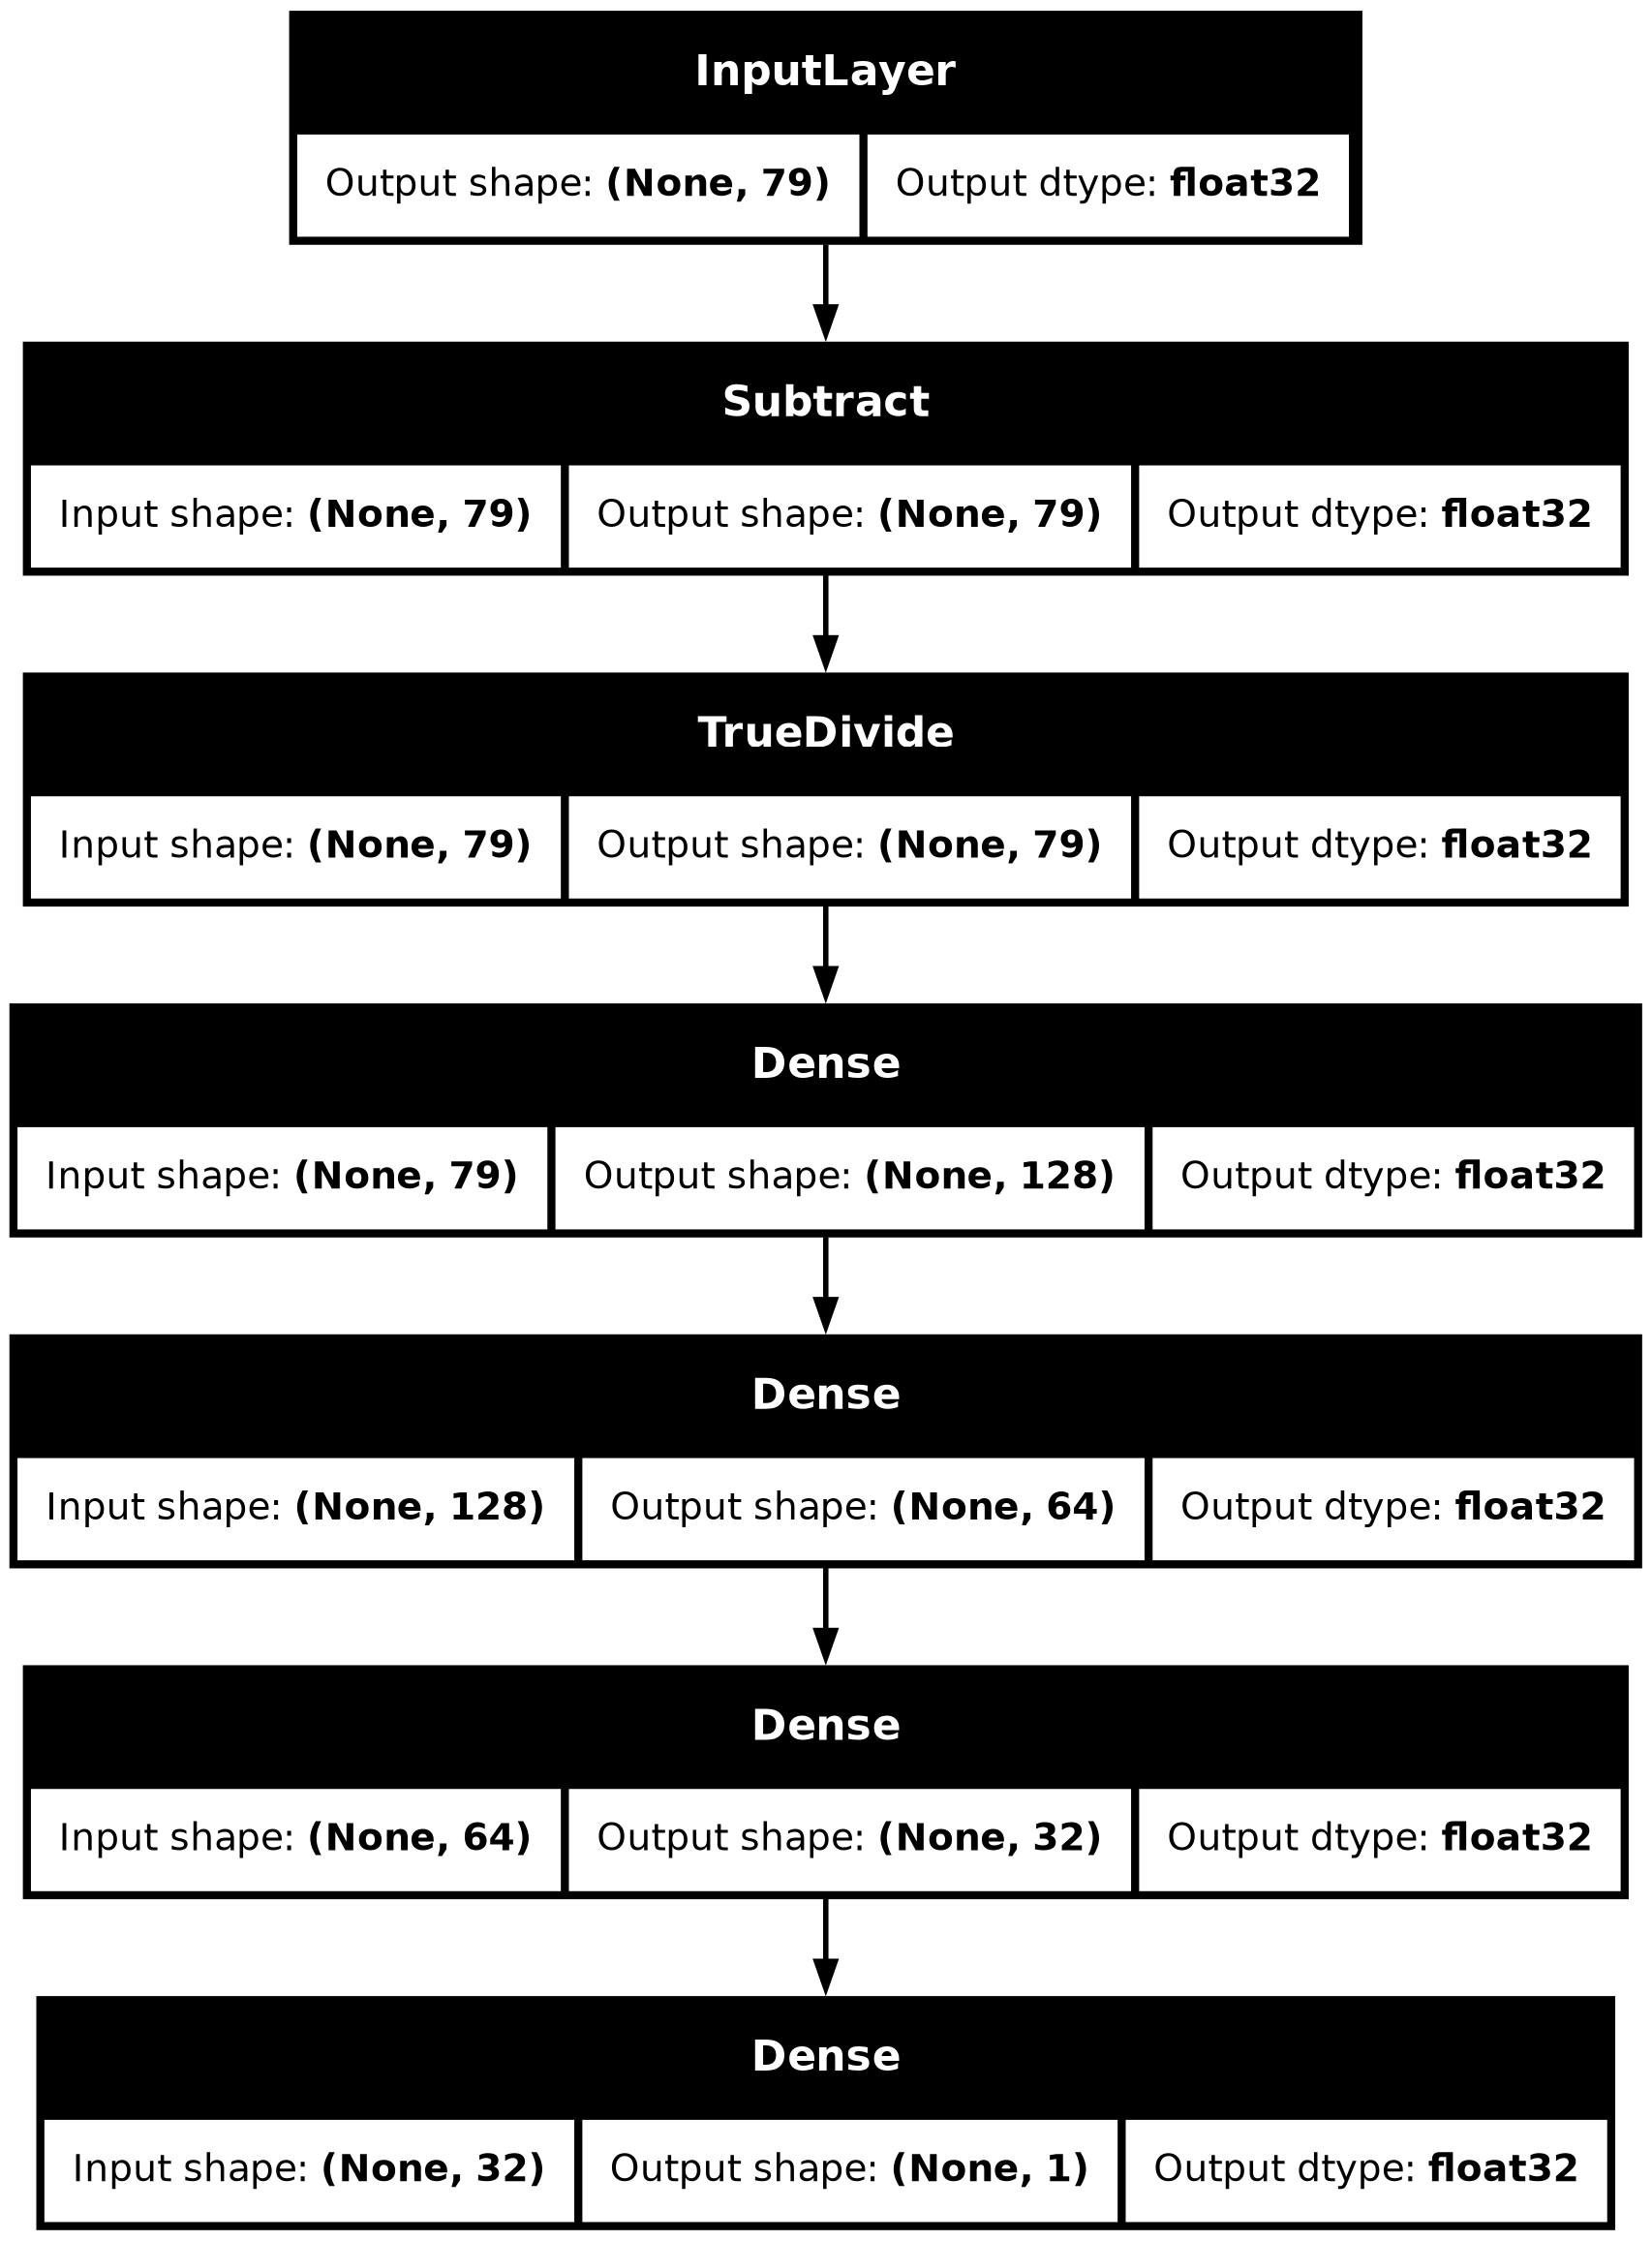

In [ ]:
model = get_model()
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

## 5. Training or loading model

In [ ]:
if CFG.is_training:
    model = get_model()
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            filepath='model.keras',  # Path where model is saved
            monitor='val_r2',  # Monitor validation loss
            save_best_only=True,  # Save only the best model
            save_weights_only=False,  # Save the entire model, not just weights
            mode='max',  # Minimize the monitored metric
            verbose=1
        ),
        tf.keras.callbacks.TerminateOnNaN(),  # Stop training if NaN loss is encountered
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',  # Monitor validation loss
            patience=5,  # Number of epochs with no improvement after which training will stop
            mode='min',  # Minimize the monitored metric
            verbose=1
        )
    ]
    # Train the model with callbacks
    history = model.fit(
        train_ds,
        epochs=30,
        validation_data=valid_ds,
        callbacks=callbacks,
        verbose=1
    )
else:
    model = tf.keras.models.load_model("/kaggle/input/jane-street-rmf-keras-model/model.keras", custom_objects={
        "R2Metric": R2Metric
    })
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 79)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 61,829 (241.52 KB)

 Trainable params: 20,609 (80.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 41,220 (161.02 KB)

## 6. Model Evaluation

In [ ]:
val_loss, val_r2 = model.evaluate(valid_ds)
print(f"Validation R2:{val_r2:.4f}")

3031/3031 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 0.2841 - r2: -0.0027
Validation R2:-0.0052


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


## 7. Create submission pipeline

The evaluation API requires that you set up a server which will respond to inference requests. We have already defined the server; you just need write the predict function. When we evaluate your submission on the hidden test set the client defined in `jane_street_gateway` will run in a different container with direct access to the hidden test set and hand off the data timestep by timestep.



Your code will always have access to the published copies of the files.

In [ ]:
lags_ : pl.DataFrame | None = None


# Replace this function with your inference code.
# You can return either a Pandas or Polars dataframe, though Polars is recommended.
# Each batch of predictions (except the very first) must be returned within 10 minutes of the batch features being provided.
def predict(test: pl.DataFrame, lags: pl.DataFrame | None) -> pl.DataFrame | pd.DataFrame:
    """Make a prediction."""
    # All the responders from the previous day are passed in at time_id == 0. We save them in a global variable for access at every time_id.
    # Use them as extra features, if you like.
    global lags_
    if lags is not None:
        lags_ = lags
    # 1. Select the required feature columns and convert to numpy array for Keras
    X_test = test.select(feature_columns).fill_null(-1).to_numpy()

    # 2. Make predictions using the Keras model
    y_pred = model.predict(X_test, batch_size=4096)

    # 3. Prepare the DataFrame for output
    predictions = test.select('row_id').with_columns(
        pl.Series("responder_6", y_pred.flatten())
    )
    # The predict function must return a DataFrame
    assert isinstance(predictions, pl.DataFrame | pd.DataFrame)
    # with columns 'row_id', 'responer_6'
    assert predictions.columns == ['row_id', 'responder_6']
    # and as many rows as the test data.
    assert len(predictions) == len(test)

    return predictions

When your notebook is run on the hidden test set, inference_server.serve must be called within 15 minutes of the notebook starting or the gateway will throw an error. If you need more than 15 minutes to load your model you can do so during the very first `predict` call, which does not have the usual 10 minute response deadline.

In [ ]:
inference_server = kaggle_evaluation.jane_street_inference_server.JSInferenceServer(predict)

if os.getenv('KAGGLE_IS_COMPETITION_RERUN'):
    inference_server.serve()
else:
    inference_server.run_local_gateway(
        (
            '/kaggle/input/jane-street-real-time-market-data-forecasting/test.parquet',
            '/kaggle/input/jane-street-real-time-market-data-forecasting/lags.parquet',
        )
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
